In [2]:
import pandas as pd
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from datetime import datetime

# Load the JSONL file
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = [json.loads(line.strip()) for line in f]
    return pd.DataFrame(data)

df = load_jsonl('av_patentdata.jsonl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   lens_id               667 non-null    object
 1   date_published        667 non-null    object
 2   claims                667 non-null    object
 3   description           667 non-null    object
 4   earliest_claim_date   667 non-null    object
 5   applicant_name        667 non-null    object
 6   cpc_symbols           667 non-null    object
 7   invention_title_text  667 non-null    object
 8   abstract_text         667 non-null    object
dtypes: object(9)
memory usage: 47.0+ KB


In [5]:
df.describe(include='all')

,lens_id,date_published,claims,description,earliest_claim_date,applicant_name,cpc_symbols,invention_title_text,abstract_text
count,667,667,667,667,667,667,667,667,667
unique,667,225,667,667,468,22,667,656,658
top,143-105-704-034-927,2023-07-18,[1. A non-transitory machine-readable medium s...,RELATED APPLICATIONS This application is a con...,2017-04-28,INTEL CORP,"[G05D1/021, B60W40/09, G06N20/00, G08G1/096725...",Material spectroscopy,Computer systems and associated methods are di...
freq,1,11,1,1,8,140,1,2,3


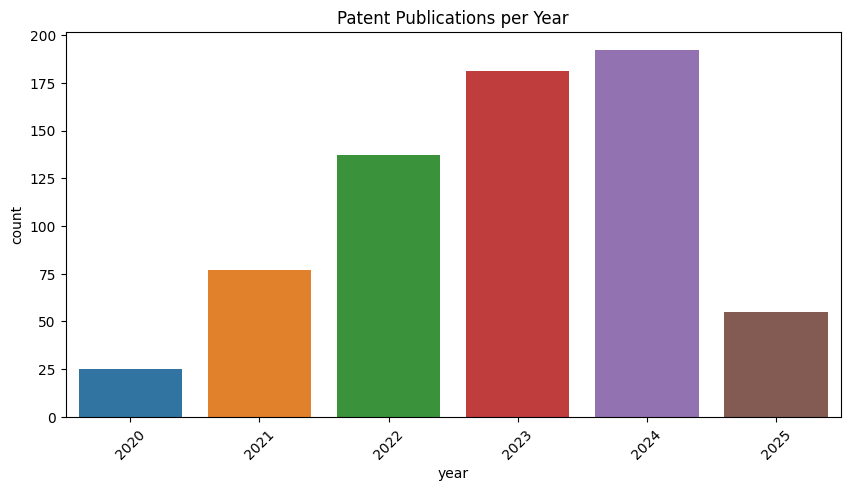

In [8]:
df['date_published'] = pd.to_datetime(df['date_published'])
df['year'] = df['date_published'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='year', order=sorted(df['year'].dropna().unique()))
plt.xticks(rotation=45)
plt.title('Patent Publications per Year')
plt.show()

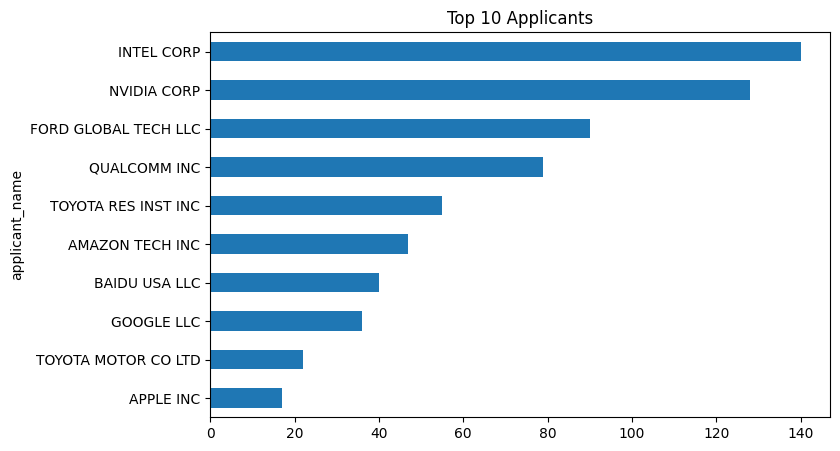

In [10]:
top_applicants = df['applicant_name'].value_counts().head(10)
top_applicants.plot(kind='barh', title='Top 10 Applicants', figsize=(8, 5))
plt.gca().invert_yaxis()
plt.show()

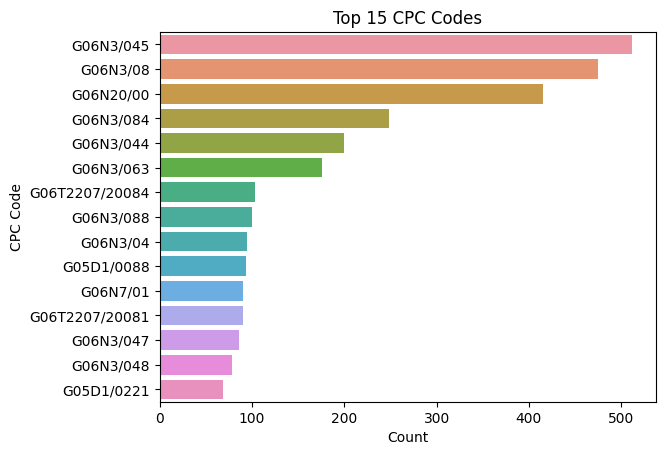

In [11]:
all_cpc = [code for sublist in df['cpc_symbols'] for code in sublist]
cpc_counts = Counter(all_cpc).most_common(15)
cpc_df = pd.DataFrame(cpc_counts, columns=['CPC Code', 'Count'])

sns.barplot(data=cpc_df, y='CPC Code', x='Count')
plt.title('Top 15 CPC Codes')
plt.show()

In [13]:
def word_count(text):
    if isinstance(text, str):
        return len(text.split())
    return 0

df['abstract_len'] = df['abstract_text'].apply(word_count)
df['title_len'] = df['invention_title_text'].apply(word_count)
df['desc_len'] = df['description'].apply(word_count)
df['claims_len'] = df['claims'].apply(lambda x: sum(word_count(claim) for claim in x if isinstance(claim, str)))

df[['abstract_len', 'title_len', 'desc_len', 'claims_len']].describe()

,abstract_len,title_len,desc_len,claims_len
count,667.000000,667.000000,667.000000,667.000000
mean,111.389805,8.056972,17914.041979,1418.695652
std,32.694616,3.537834,14322.006383,541.172275
min,29.000000,2.000000,3341.000000,378.000000
25%,87.000000,6.000000,8975.500000,1055.500000
50%,116.000000,8.000000,13183.000000,1334.000000
75%,140.000000,10.000000,21582.500000,1673.500000
max,218.000000,31.000000,95369.000000,5191.000000


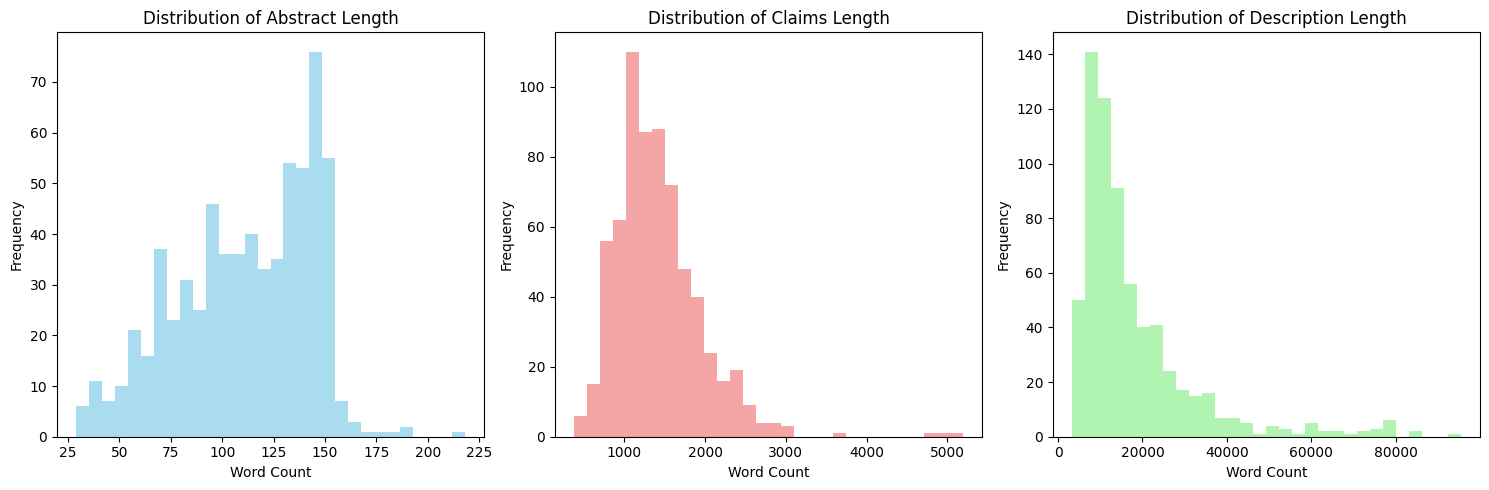

In [16]:
# Create 3 separate histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Create a figure and a set of subplots

# Plot for 'abstract_len' with a custom color
df['abstract_len'].plot(kind='hist', alpha=0.7, bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Abstract Length')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('Frequency')

# Plot for 'claims_len' with a custom color
df['claims_len'].plot(kind='hist', alpha=0.7, bins=30, ax=axes[1], color='lightcoral')
axes[1].set_title('Distribution of Claims Length')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')

# Plot for 'desc_len' with a custom color
df['desc_len'].plot(kind='hist', alpha=0.7, bins=30, ax=axes[2], color='lightgreen')
axes[2].set_title('Distribution of Description Length')
axes[2].set_xlabel('Word Count')
axes[2].set_ylabel('Frequency')

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

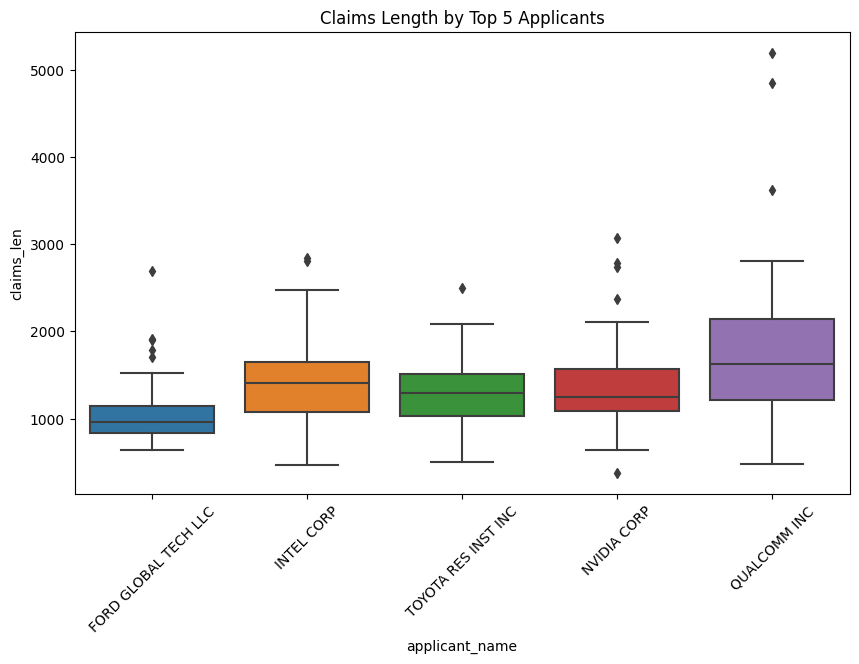

In [24]:
top_5_applicants = df['applicant_name'].value_counts().head(5).index.tolist()
subset = df[df['applicant_name'].isin(top_5_applicants)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=subset, x='applicant_name', y='claims_len')
plt.xticks(rotation=45)
plt.title('Claims Length by Top 5 Applicants')
plt.show()

C:\Users\Aniket Shinde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Aniket Shinde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


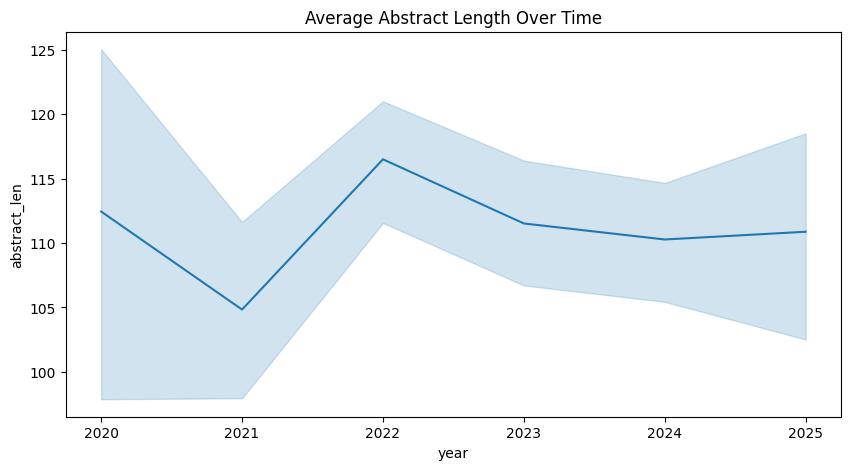

In [25]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='year', y='abstract_len')
plt.title('Average Abstract Length Over Time')
plt.show()

In [27]:
# Group by CPC codes and analyze abstracts
cpc_terms = {}
for cpc in df['cpc_symbols'].explode().dropna().unique():
    subset_texts = df[df['cpc_symbols'].apply(lambda x: cpc in x)]['abstract_text']
    cpc_terms[cpc] = get_word_freq(subset_texts, top_n=5)

# View terms for top CPC
print("Top words in CPC code:", list(cpc_terms.keys())[0])
print(cpc_terms[list(cpc_terms.keys())[0]])

Top words in CPC code: G05D1/021
[('driving', 14), ('virtual', 10), ('style', 9), ('vehicles', 8), ('autonomous', 6)]


In [33]:
import pandas as pd
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load spaCy model
nlp = spacy.load("en_core_web_sm")  # Use small model for EDA purposes

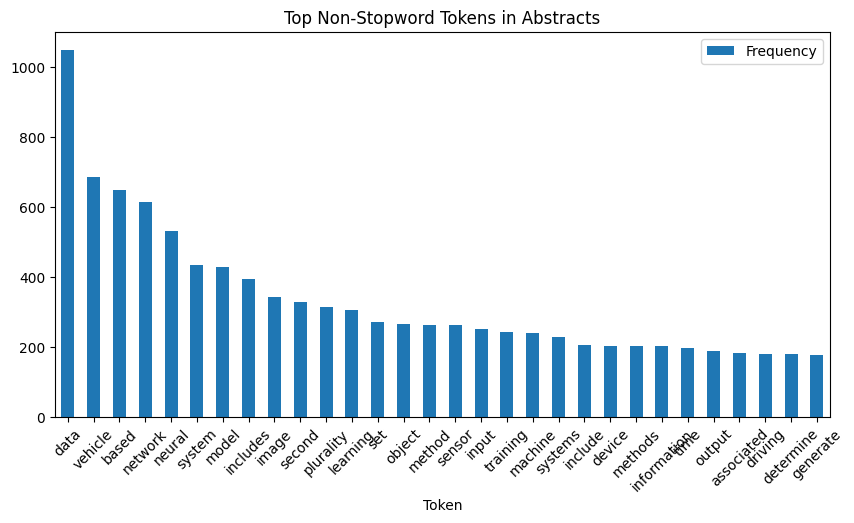

In [35]:
def tokenize(texts):
    tokens = []
    for doc in nlp.pipe(texts, disable=["parser", "ner"]):
        tokens.extend([token.text.lower() for token in doc if not token.is_stop and token.is_alpha])
    return tokens

abstract_tokens = tokenize(df['abstract_text'].dropna().tolist())
abstract_token_freq = Counter(abstract_tokens).most_common(30)

# Plot
df_freq = pd.DataFrame(abstract_token_freq, columns=['Token', 'Frequency'])
df_freq.plot.bar(x='Token', y='Frequency', figsize=(10, 5), title='Top Non-Stopword Tokens in Abstracts')
plt.xticks(rotation=45)
plt.show()

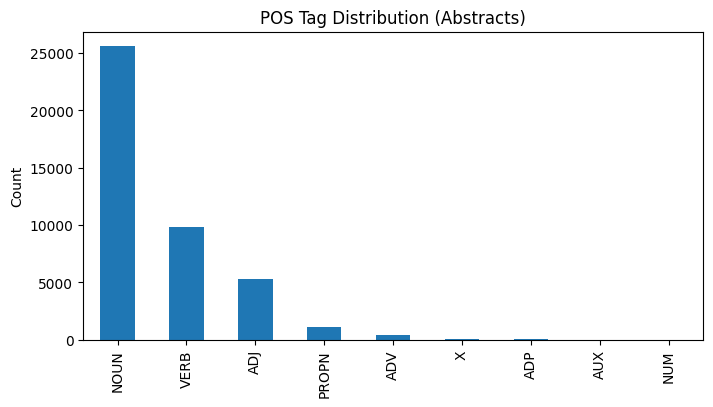

In [37]:
def get_pos_distribution(texts):
    pos_counts = Counter()
    for doc in nlp.pipe(texts, disable=["ner"]):
        pos_counts.update([token.pos_ for token in doc if not token.is_stop and token.is_alpha])
    return pos_counts

pos_counts = get_pos_distribution(df['abstract_text'].dropna().tolist())

# Plot
pd.Series(pos_counts).sort_values(ascending=False).plot.bar(title='POS Tag Distribution (Abstracts)', figsize=(8, 4))
plt.ylabel("Count")
plt.show()

C:\Users\Aniket Shinde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


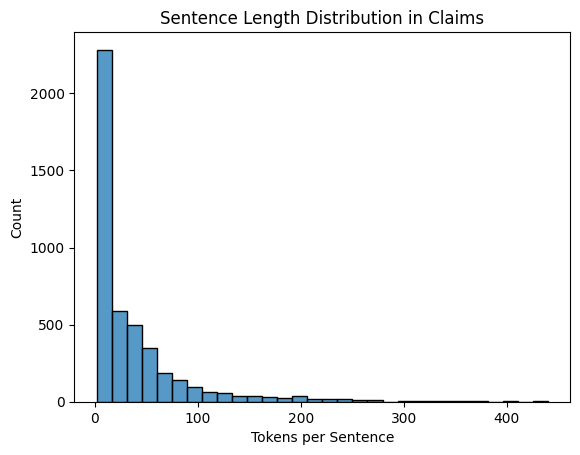

In [38]:
def sentence_stats(texts):
    sent_lens = []
    for doc in nlp.pipe(texts):
        sent_lens.extend([len(sent) for sent in doc.sents])
    return sent_lens

sent_lengths = sentence_stats(df['claims'].dropna().sample(n=100).apply(' '.join).tolist())  # Sample for speed

sns.histplot(sent_lengths, bins=30)
plt.title("Sentence Length Distribution in Claims")
plt.xlabel("Tokens per Sentence")
plt.show()

C:\Users\Aniket Shinde\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


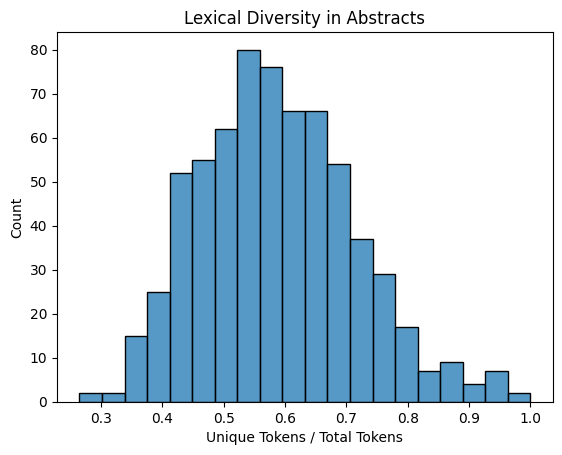

In [40]:
def lexical_diversity(texts):
    diversity_scores = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        tokens = [t.text.lower() for t in doc if not t.is_stop and t.is_alpha]
        if len(tokens) > 0:
            diversity_scores.append(len(set(tokens)) / len(tokens))
    return diversity_scores

diversity = lexical_diversity(df['abstract_text'].dropna().tolist())

sns.histplot(diversity, bins=20)
plt.title("Lexical Diversity in Abstracts")
plt.xlabel("Unique Tokens / Total Tokens")
plt.show()

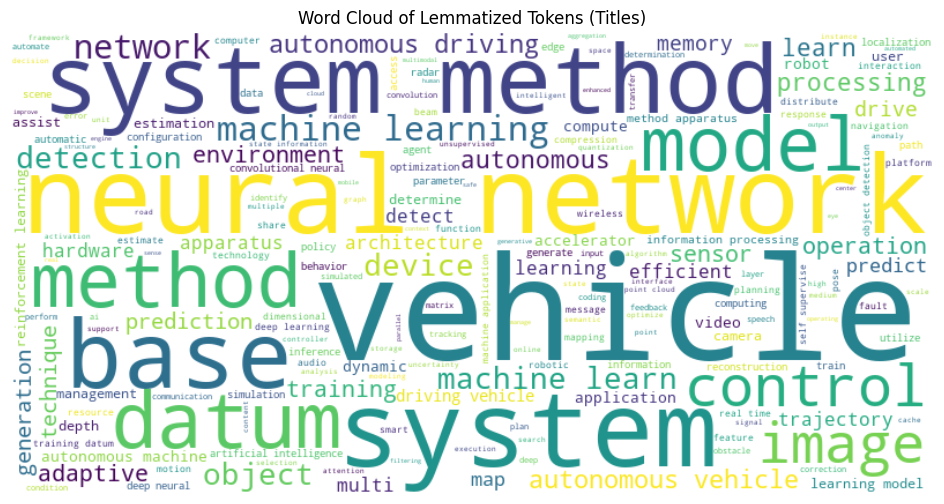

In [41]:
def get_lemmas(texts):
    lemmas = []
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        lemmas.extend([token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha])
    return lemmas

lemmas = get_lemmas(df['invention_title_text'].dropna().tolist())
text_blob = ' '.join(lemmas)

wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Lemmatized Tokens (Titles)')
plt.show()